In [1]:
pip install nba-api

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import skew

from nba_api.stats.static import teams, players
from nba_api.stats.endpoints import commonteamroster, leaguestandings, teamyearbyyearstats,\
                                    teamdashboardbyyearoveryear,playercareerstats

import matplotlib

## Get and clean some data

In [3]:
# Get season stats for all teams and all seasons
all_teams = teams.get_teams()
team_stats = []
for team in all_teams:
    team_stats.append(teamyearbyyearstats.TeamYearByYearStats(team_id=team["id"]).get_data_frames()[0])

teams_df = pd.concat(team_stats)
teams_df.head()
teams_df_copy = teams_df.copy()

In [4]:
# Remove some unneeded columns
drop_columns = ["CONF_RANK", "DIV_RANK","WINS", "LOSSES", "CONF_COUNT", "DIV_COUNT"]
teams_df.drop(drop_columns, axis=1, inplace=True, errors="ignore")
print(teams_df.columns)
teams_df.head()


Index(['TEAM_ID', 'TEAM_CITY', 'TEAM_NAME', 'YEAR', 'GP', 'WIN_PCT', 'PO_WINS',
       'PO_LOSSES', 'NBA_FINALS_APPEARANCE', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'PF', 'STL', 'TOV', 'BLK', 'PTS', 'PTS_RANK'],
      dtype='object')


,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,GP,WIN_PCT,PO_WINS,PO_LOSSES,NBA_FINALS_APPEARANCE,FGM,...,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS,PTS_RANK
0,1610612737,Tri-Cities,Blackhawks,1949-50,64,0.453,1,2,N/A,1818,...,0,0,0,1330,2057,0,0,0,5313,10
1,1610612737,Tri-Cities,Blackhawks,1950-51,68,0.368,0,0,N/A,1988,...,0,0,0,1476,2092,0,0,0,5730,3
2,1610612737,Milwaukee,Hawks,1951-52,66,0.258,0,0,N/A,1674,...,0,0,0,1229,1848,0,0,0,4833,10
3,1610612737,Milwaukee,Hawks,1952-53,71,0.380,0,0,N/A,1873,...,0,0,0,1427,2120,0,0,0,5389,9
4,1610612737,Milwaukee,Hawks,1953-54,72,0.292,0,0,N/A,1757,...,0,0,0,1298,1771,0,0,0,5038,9


In [120]:
# First time three point line
print("First time three point line: ",teams_df[teams_df["FG3A"]==0]["YEAR"].max())

#First time further statistics as REB, TOV
print("First time stats as REB and TOV included", teams_df[teams_df["REB"]==0]["YEAR"].max())

First time three point line:  1981-82
First time stats as REB and TOV included 1972-73


In [122]:
# How many entries would fall if only consider after 1981-82 season
new_teams_df = teams_df[teams_df["YEAR"]>"1982-83"].copy()
print("Rows before/after deleting entries after 1981/82 season: {}/{}".format(len(teams_df), len(new_teams_df)))

# Fill nba finals appearance with 0 where N/A
new_teams_df.loc[new_teams_df["NBA_FINALS_APPEARANCE"]=="N/A","NBA_FINALS_APPEARANCE"] = 0
new_teams_df.head()

Rows before/after deleting entries after 1981/82 season: 1507/1043


,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,GP,WIN_PCT,PO_WINS,PO_LOSSES,NBA_FINALS_APPEARANCE,FGM,...,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS,PTS_RANK
34,1610612737,Atlanta,Hawks,1983-84,82,0.488,2,3,0,3230,...,1112,2232,3344,1827,2091,626,1329,558,8321,23
35,1610612737,Atlanta,Hawks,1984-85,82,0.415,0,0,0,3444,...,1161,2345,3506,2009,2047,665,1475,541,8743,20
36,1610612737,Atlanta,Hawks,1985-86,82,0.610,4,5,0,3447,...,1249,2405,3654,2025,2170,736,1483,434,8906,17
37,1610612737,Atlanta,Hawks,1986-87,82,0.695,4,5,0,3435,...,1350,2478,3828,2077,2152,700,1279,511,9024,12
38,1610612737,Atlanta,Hawks,1987-88,82,0.610,6,6,0,3443,...,1228,2379,3607,2062,2050,635,1225,537,8844,13


In [7]:
# Function to convert a year to year-1
def to_previous_year(year):
    if year[5:7]!="00": 
        prev_year = str(int(year[0:4])+-1).zfill(2)+"-"+str(int(year[5:7])-1).zfill(2)
    else: 
        prev_year = str(int(year[0:4])+-1).zfill(2)+"-99"
    return prev_year

In [8]:
# Create a new dataframe where the WIN_PCT and YEAR are togehter with the stats from the previous year
keep_columns = ["TEAM_ID","TEAM_CITY", "TEAM_NAME","YEAR","WIN_PCT", "GP"]
before_season_df = new_teams_df[keep_columns].copy()
before_season_df["PREV_YEAR"] = before_season_df["YEAR"].apply(lambda x: to_previous_year(x))
before_season_df = pd.merge(before_season_df,new_teams_df, left_on=["PREV_YEAR", "TEAM_ID"], \
                            right_on=["YEAR","TEAM_ID"], how="left")

# Remove duplicate values from merge, besides WIN_PCT, the one from the previous year can be strong predictor
drop_columns= [x+"_y" for x in keep_columns if x!="TEAM_ID" and x!="WIN_PCT"]
before_season_df.drop(drop_columns, axis=1, inplace=True)
before_season_df.rename(columns={"TEAM_CITY_x":"TEAM_CITY", "TEAM_NAME_x":"TEAM_NAME","YEAR_x":"YEAR",\
                                 "WIN_PCT_x":"WIN_PCT","GP_x":"GP", "WIN_PCT_y":"PREV_WIN_PCT"}, inplace=True)
before_season_df = before_season_df[before_season_df["YEAR"]>"1983-84"]

print(before_season_df.isna().sum())

# Drop 8 rows where NaN
before_season_df.dropna(axis=0, inplace=True)

# Divide Final Appearance into appered/won variable
before_season_df["WON"] = before_season_df["NBA_FINALS_APPEARANCE"]
before_season_df.loc[before_season_df["NBA_FINALS_APPEARANCE"]=="LEAGUE CHAMPION","NBA_FINALS_APPEARANCE"] = 1
before_season_df.loc[before_season_df["NBA_FINALS_APPEARANCE"]=="FINALS APPEARANCE","NBA_FINALS_APPEARANCE"] = 1
before_season_df.loc[before_season_df["WON"]=="LEAGUE CHAMPION","WON"] = 1
before_season_df.loc[before_season_df["WON"]=="FINALS APPEARANCE","WON"] = 0
before_season_df = before_season_df.astype({"NBA_FINALS_APPEARANCE":int, "WON":int})

# Add column for playoff games played
before_season_df["PO_GAMES"] = before_season_df["PO_WINS"]+before_season_df["PO_LOSSES"]

before_season_df.head()


TEAM_ID                  0
TEAM_CITY                0
TEAM_NAME                0
YEAR                     0
WIN_PCT                  0
GP                       0
PREV_YEAR                0
PREV_WIN_PCT             8
PO_WINS                  8
PO_LOSSES                8
NBA_FINALS_APPEARANCE    8
FGM                      8
FGA                      8
FG_PCT                   8
FG3M                     8
FG3A                     8
FG3_PCT                  8
FTM                      8
FTA                      8
FT_PCT                   8
OREB                     8
DREB                     8
REB                      8
AST                      8
PF                       8
STL                      8
TOV                      8
BLK                      8
PTS                      8
PTS_RANK                 8
dtype: int64


,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,WIN_PCT,GP,PREV_YEAR,PREV_WIN_PCT,PO_WINS,PO_LOSSES,...,REB,AST,PF,STL,TOV,BLK,PTS,PTS_RANK,WON,PO_GAMES
1,1610612737,Atlanta,Hawks,1984-85,0.415,82,1983-84,0.488,2.0,3.0,...,3344.0,1827.0,2091.0,626.0,1329.0,558.0,8321.0,23.0,0,5.0
2,1610612737,Atlanta,Hawks,1985-86,0.610,82,1984-85,0.415,0.0,0.0,...,3506.0,2009.0,2047.0,665.0,1475.0,541.0,8743.0,20.0,0,0.0
3,1610612737,Atlanta,Hawks,1986-87,0.695,82,1985-86,0.610,4.0,5.0,...,3654.0,2025.0,2170.0,736.0,1483.0,434.0,8906.0,17.0,0,9.0
4,1610612737,Atlanta,Hawks,1987-88,0.610,82,1986-87,0.695,4.0,5.0,...,3828.0,2077.0,2152.0,700.0,1279.0,511.0,9024.0,12.0,0,9.0
5,1610612737,Atlanta,Hawks,1988-89,0.634,82,1987-88,0.610,6.0,6.0,...,3607.0,2062.0,2050.0,635.0,1225.0,537.0,8844.0,13.0,0,12.0


In [9]:
# Exlude the 2019/2020 season because thats what really interests us.
season_2019_df = before_season_df[before_season_df["YEAR"]=="2019-20"].copy()
before_season_df = before_season_df[before_season_df["YEAR"]!="2019-20"].copy()

## First Data Exploration

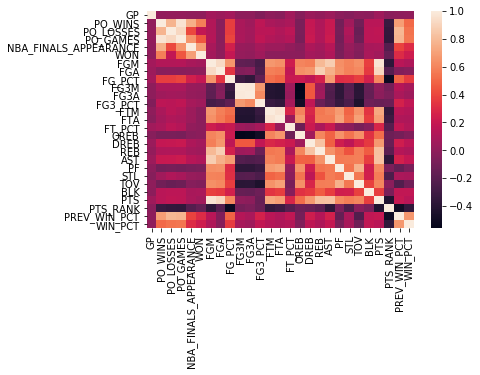

In [10]:
features = ['GP','PO_WINS', 'PO_LOSSES', "PO_GAMES",'NBA_FINALS_APPEARANCE', "WON",'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'PF', 'STL', 'TOV', 'BLK', 'PTS',
       'PTS_RANK',"PREV_WIN_PCT",'WIN_PCT']
%matplotlib inline
# calculate the correlation matrix
corr = before_season_df[features].corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

Intersting observations: 
    - Higghest Correlation seems to be with Playoff games played
    - Good pts rank hihg correlation
    - Free throws and 3pt negatively correlated

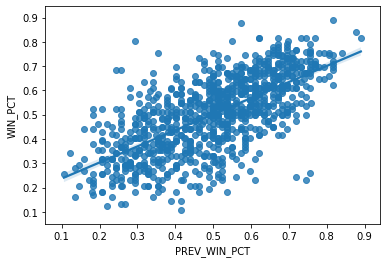

In [11]:
sns.regplot(before_season_df["PREV_WIN_PCT"], before_season_df["WIN_PCT"])

## First Simple baseline model

In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [13]:
# Check what a model which only predicts using the previous year win_pct would do
features = ["PREV_WIN_PCT"]
X = before_season_df[features]
Y = before_season_df["WIN_PCT"]

def cv(model):
    return np.sqrt(-cross_val_score(model, X, Y, scoring="neg_mean_squared_error", cv=5))

# Simple Linear Regression
#lr = make_pipeline(RobustScaler(), LinearRegression())
lr = LinearRegression()
scores = np.sqrt(-cross_val_score(lr, X, Y, scoring="neg_mean_squared_error", cv=5))
lr.fit(X,Y)
print("RMSE Linear Regression: ", round(scores.mean(),3))

RMSE Linear Regression:  0.115


In [14]:
features = ['GP','PO_GAMES', 'NBA_FINALS_APPEARANCE', "WON",'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'PF', 'STL', 'TOV', 'BLK', 'PTS',
       'PTS_RANK', "PREV_WIN_PCT"]
X = before_season_df[features]
Y = before_season_df["WIN_PCT"]

def cv(model):
    return np.sqrt(-cross_val_score(model, X, Y, scoring="neg_mean_squared_error", cv=5))

# Simple Linear Regression
lr = LinearRegression()
scores = np.sqrt(-cross_val_score(lr, X, Y, scoring="neg_mean_squared_error", cv=5))
lr.fit(X,Y)
print("RMSE Linear Regression: ", round(scores.mean(),3))

RMSE Linear Regression:  0.115


Min value: 0.11506216354581796


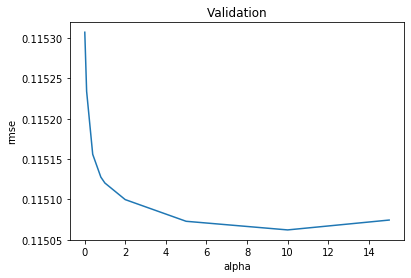

In [15]:
# Ridge Regression
alphas = [0.01,0.1, 0.4,0.8,1.0,2.0,5.0,10.0,15.0]
cv_ridge = [cv(make_pipeline(RobustScaler(), Ridge(alpha))).mean() for alpha in alphas]
print("Min value: {}".format(min(cv_ridge)))
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()


Min value: 0.11497961410036346


/home/lars/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023593835287258003, tolerance: 0.0018501454242038215
  positive)


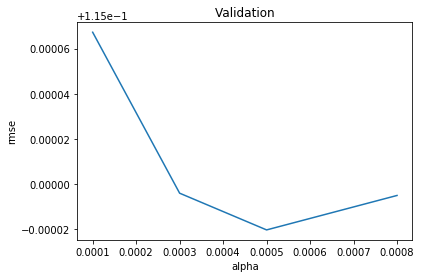

Lasso picked 17 variables and eliminated the other 7 variables


In [16]:
# Lasso REgression
alphas = [0.0008,0.0005, 0.0003,0.0001]
cv_ridge = [cv(make_pipeline(RobustScaler(), Lasso(alpha))).mean() for alpha in alphas]
print("Min value: {}".format(min(cv_ridge)))
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

lasso = make_pipeline(RobustScaler(), Lasso(0.0005))
lasso.fit(X,Y)
lasso[1].coef_

coef = pd.Series(lasso[1].coef_, index = X.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

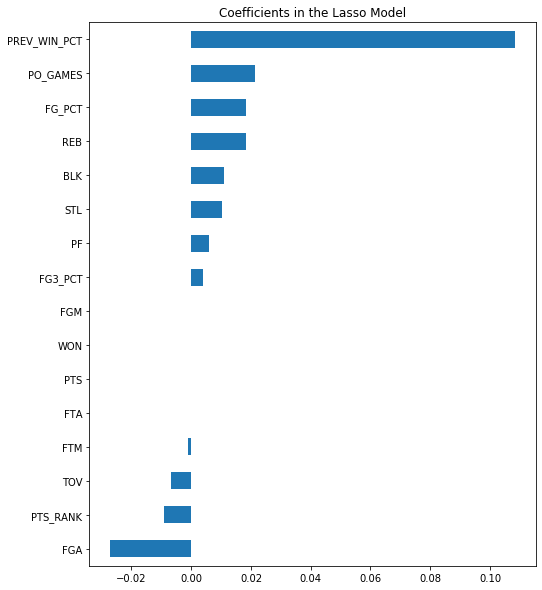

In [17]:
imp_coef = pd.concat([coef.sort_values().head(8),
                     coef.sort_values().tail(8)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")


In [18]:
# Predict season standing with this
def predict_season_standing(model, df, features):
    win_pct = model.predict(df[features])
    df["PRED_WIN_PCT"] = win_pct
predict_season_standing(lasso, season_2019_df, features)
season_2019_df.sort_values("PRED_WIN_PCT", ascending=False)[["TEAM_NAME","PRED_WIN_PCT", "WIN_PCT"]].head(30)

,TEAM_NAME,PRED_WIN_PCT,WIN_PCT
276,Warriors,0.676453,0.231
456,Bucks,0.671122,0.767
876,Raptors,0.660424,0.736
740,Trail Blazers,0.605725,0.473
666,76ers,0.600893,0.589
239,Nuggets,0.589726,0.630
913,Jazz,0.575809,0.611
313,Rockets,0.574012,0.611
73,Celtics,0.562908,0.667
350,Clippers,0.558717,0.681


Prevvious years winning percentage is by far the most important feature, whihc makes sense. Almost all the important features are correlated with this. What needs to be added to the model is what happens in the offseason, which new players were added etc.

## Improve model by getting player stats from the previous season from all the players for the current season

In [19]:
"""
# Load all player statistiscs


player_stats = []
all_players = players.get_players()
for player in all_players:
    id = player['id']
    player_stats.append(playercareerstats.PlayerCareerStats(player_id=id).get_data_frames()[0])
player_stats

player_df = pd.concat(player_stats)
# save as csv to not have to load again
player_df.to_csv("/home/lars/Dokumente/projects/Coursera_Capstone/players.csv")
"""

'\n# Load all player statistiscs\n\n\nplayer_stats = []\nall_players = players.get_players()\nfor player in all_players:\n    id = player[\'id\']\n    player_stats.append(playercareerstats.PlayerCareerStats(player_id=id).get_data_frames()[0])\nplayer_stats\n\nplayer_df = pd.concat(player_stats)\n# save as csv to not have to load again\nplayer_df.to_csv("/home/lars/Dokumente/projects/Coursera_Capstone/players.csv")\n'

In [20]:
player_df = pd.read_csv("/home/lars/Dokumente/projects/Coursera_Capstone/players.csv")
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26968 entries, 0 to 26967
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26968 non-null  int64  
 1   PLAYER_ID          26968 non-null  int64  
 2   SEASON_ID          26968 non-null  object 
 3   LEAGUE_ID          26968 non-null  int64  
 4   TEAM_ID            26968 non-null  int64  
 5   TEAM_ABBREVIATION  26959 non-null  object 
 6   PLAYER_AGE         26968 non-null  float64
 7   GP                 26968 non-null  int64  
 8   GS                 20486 non-null  float64
 9   MIN                26199 non-null  float64
 10  FGM                26968 non-null  int64  
 11  FGA                26968 non-null  int64  
 12  FG_PCT             26954 non-null  float64
 13  FG3M               20935 non-null  float64
 14  FG3A               20935 non-null  float64
 15  FG3_PCT            20713 non-null  float64
 16  FTM                269

In [21]:
drop_columns = ["TEAM_ABBREVIATION", "PLAYER_AGE", "Unnamed: 0", "LEAGUE_ID", "FG_PCT", "FG3_PCT", "FT_PCT", "TEAM_ID"]
player_df.drop(drop_columns, axis=1, inplace=True)

In [22]:
player_df.columns

Index(['PLAYER_ID', 'SEASON_ID', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG3M',
       'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS'],
      dtype='object')

In [23]:
player_df = player_df[player_df["SEASON_ID"]>"1982-83"]

In [24]:
player_df.fillna(0, inplace=True)
player_df.isnull().sum()

PLAYER_ID    0
SEASON_ID    0
GP           0
GS           0
MIN          0
FGM          0
FGA          0
FG3M         0
FG3A         0
FTM          0
FTA          0
OREB         0
DREB         0
REB          0
AST          0
STL          0
BLK          0
TOV          0
PF           0
PTS          0
dtype: int64

In [25]:
# If changed team during season, take tot value
new_df = player_df.groupby(["PLAYER_ID", "SEASON_ID"], as_index=False).max()
new_df.columns

Index(['PLAYER_ID', 'SEASON_ID', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG3M',
       'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS'],
      dtype='object')

In [28]:
# # Get for each year and team the summed stats of the previous year performance of the players
# features = ['FGM', 'FGA', 'FG3M',
#        'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
#        'PF', 'PTS']
# stats = []
# for index, row in before_season_df.iterrows():
#     season = row["YEAR"]
#     prev_season = row["PREV_YEAR"]
#     team_id = row["TEAM_ID"]
#     time.sleep(1)
#     players = commonteamroster.CommonTeamRoster(team_id=team_id, season=season).get_data_frames()[0]["PLAYER_ID"]
#     time.sleep(1)
#     prev_players = commonteamroster.CommonTeamRoster(team_id=team_id, season=prev_season).get_data_frames()[0]["PLAYER_ID"]

#     summed_stats = pd.DataFrame(new_df[(new_df["PLAYER_ID"].isin(players)) & (new_df["SEASON_ID"]==prev_season)][features].sum(axis=0)).transpose()
#     summed_stats["YEAR"] = season
#     summed_stats["TEAM_ID"] = team_id
    
#     diff_players = len(set(players).difference(set(prev_players)))
#     summed_stats["NEW_PLAYERS"] = diff_players

#     stats.append(summed_stats)

# summed_stats = pd.concat(stats, axis=0)
# summed_stats.head()

,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,YEAR,TEAM_ID,NEW_PLAYERS
0,2892.0,6087.0,31.0,134.0,1577.0,2121.0,1091.0,2005.0,3096.0,2010.0,687.0,556.0,1266.0,2224.0,7392.0,1984-85,1610612737,8
0,3305.0,6968.0,86.0,282.0,1853.0,2405.0,1055.0,2078.0,3133.0,2135.0,631.0,516.0,1371.0,1878.0,8549.0,1985-86,1610612737,6
0,3824.0,7913.0,94.0,363.0,1963.0,2702.0,1301.0,2479.0,3780.0,2155.0,831.0,448.0,1488.0,2219.0,9705.0,1986-87,1610612737,3
0,3559.0,7472.0,104.0,381.0,2178.0,2853.0,1386.0,2655.0,4041.0,2566.0,768.0,525.0,1386.0,2290.0,9400.0,1987-88,1610612737,3
0,3863.0,8106.0,123.0,410.0,2504.0,3197.0,1270.0,2332.0,3602.0,2450.0,716.0,470.0,1513.0,1960.0,10353.0,1988-89,1610612737,6


In [29]:
#summed_stats.to_csv("/home/lars/Dokumente/projects/Coursera_Capstone/team_stats.csv")

In [30]:
summed_stats = pd.read_csv("/home/lars/Dokumente/projects/Coursera_Capstone/team_stats.csv")

In [31]:
# Join summed_stats and before_season_df
season_df = before_season_df.merge(summed_stats, on=["YEAR", "TEAM_ID"], how='left')
season_df.head()

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,WIN_PCT,GP,PREV_YEAR,PREV_WIN_PCT,PO_WINS,PO_LOSSES,...,OREB_y,DREB_y,REB_y,AST_y,STL_y,BLK_y,TOV_y,PF_y,PTS_y,NEW_PLAYERS
0,1610612737,Atlanta,Hawks,1984-85,0.415,82,1983-84,0.488,2.0,3.0,...,1091.0,2005.0,3096.0,2010.0,687.0,556.0,1266.0,2224.0,7392.0,8
1,1610612737,Atlanta,Hawks,1985-86,0.610,82,1984-85,0.415,0.0,0.0,...,1055.0,2078.0,3133.0,2135.0,631.0,516.0,1371.0,1878.0,8549.0,6
2,1610612737,Atlanta,Hawks,1986-87,0.695,82,1985-86,0.610,4.0,5.0,...,1301.0,2479.0,3780.0,2155.0,831.0,448.0,1488.0,2219.0,9705.0,3
3,1610612737,Atlanta,Hawks,1987-88,0.610,82,1986-87,0.695,4.0,5.0,...,1386.0,2655.0,4041.0,2566.0,768.0,525.0,1386.0,2290.0,9400.0,3
4,1610612737,Atlanta,Hawks,1988-89,0.634,82,1987-88,0.610,6.0,6.0,...,1270.0,2332.0,3602.0,2450.0,716.0,470.0,1513.0,1960.0,10353.0,6


In [96]:
season_df["PTS_diff"] = season_df["PTS_x"]-season_df["PTS_y"]
season_df["AST_diff"] = season_df["AST_x"]-season_df["AST_y"]
season_df["REB_diff"] = season_df["REB_x"]-season_df["REB_y"]
season_df["FGM_diff"] = season_df["FGM_x"]-season_df["FGM_y"]
season_df["TOV_diff"] = season_df["TOV_x"]-season_df["TOV_y"]
season_df["FG_PCT_y"] = season_df["FGM_y"]/season_df["FGA_y"]
season_df["FG3_PCT_y"] = season_df["FG3M_y"]/season_df["FG3A_y"]
season_df["FT_PCT_y"] = season_df["FTM_y"]/season_df["FTA_y"]

season_df.head()

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,WIN_PCT,GP,PREV_YEAR,PREV_WIN_PCT,PO_WINS,PO_LOSSES,...,PTS_y,NEW_PLAYERS,PTS_diff,AST_diff,REB_diff,FGM_diff,TOV_diff,FG_PCT_y,FG3_PCT_y,FT_PCT_y
0,1610612737,Atlanta,Hawks,1984-85,0.415,82,1983-84,0.488,2.0,3.0,...,7392.0,8,929.0,-183.0,248.0,338.0,63.0,0.475111,0.231343,0.743517
1,1610612737,Atlanta,Hawks,1985-86,0.610,82,1984-85,0.415,0.0,0.0,...,8549.0,6,194.0,-126.0,373.0,139.0,104.0,0.474311,0.304965,0.770478
2,1610612737,Atlanta,Hawks,1986-87,0.695,82,1985-86,0.610,4.0,5.0,...,9705.0,3,-799.0,-130.0,-126.0,-377.0,-5.0,0.483255,0.258953,0.726499
3,1610612737,Atlanta,Hawks,1987-88,0.610,82,1986-87,0.695,4.0,5.0,...,9400.0,3,-376.0,-489.0,-213.0,-124.0,-107.0,0.476312,0.272966,0.763407
4,1610612737,Atlanta,Hawks,1988-89,0.634,82,1987-88,0.610,6.0,6.0,...,10353.0,6,-1509.0,-388.0,5.0,-420.0,-288.0,0.476561,0.300000,0.783234


In [101]:
features = ['PREV_WIN_PCT', 'PO_WINS', 'PO_LOSSES',
       'NBA_FINALS_APPEARANCE', 'PTS_RANK','FGM_y', 'FGA_y', 'FG3M_y',
       'FG3A_y', 'OREB_y', 'DREB_y', 'REB_y', 'AST_y',
       'STL_y', 'BLK_y', 'TOV_y', 'PF_y', 'PTS_y', "NEW_PLAYERS", "PTS_diff", "AST_diff","REB_diff",
           "FGM_diff","TOV_diff","FG_PCT_y","FG3_PCT_y","FT_PCT_y"]
X = season_df[features]
Y = season_df["WIN_PCT"]

def cv(model):
    return np.sqrt(-cross_val_score(model, X, Y, scoring="neg_mean_squared_error", cv=5))

# Simple Linear Regression
#lr = make_pipeline(RobustScaler(), LinearRegression())
lr = make_pipeline(RobustScaler(), Ridge(10))
scores = np.sqrt(-cross_val_score(lr, X, Y, scoring="neg_mean_squared_error", cv=5))
lr.fit(X,Y)
print("RMSE Linear Regression: ", round(scores.mean(),3))

RMSE Linear Regression:  0.103


/home/lars/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025701310914376663, tolerance: 0.0018038586471337582
  positive)
/home/lars/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0039140259446321934, tolerance: 0.0018569153930025444
  positive)
/home/lars/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001878856768050774, tolerance: 0.0018038586471337582
  positive)
/home/lars/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

Min value: 0.1027751844024809


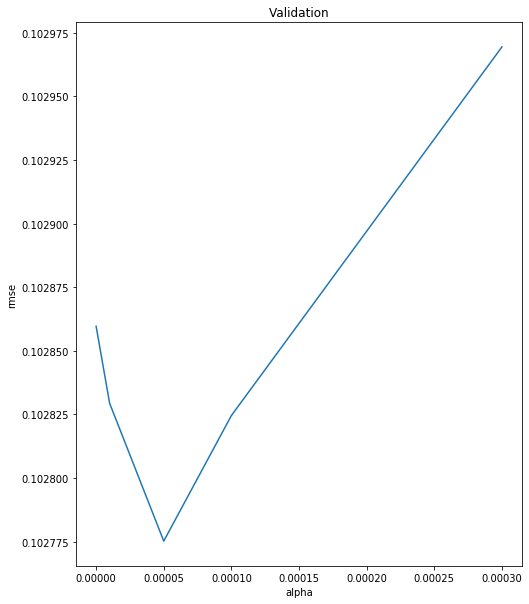

PREV_WIN_PCT             0.076984
PO_WINS                  0.004998
PO_LOSSES               -0.001295
NBA_FINALS_APPEARANCE    0.007137
PTS_RANK                -0.017926
FGM_y                   -0.126811
FGA_y                   -0.006124
FG3M_y                   0.000000
FG3A_y                   0.014638
OREB_y                   0.018477
DREB_y                   0.028924
REB_y                    0.011448
AST_y                    0.049464
STL_y                    0.021275
BLK_y                    0.025004
TOV_y                   -0.021631
PF_y                    -0.023405
PTS_y                    0.037064
NEW_PLAYERS             -0.026881
PTS_diff                -0.114731
AST_diff                -0.009688
REB_diff                 0.012731
FGM_diff                 0.018683
TOV_diff                 0.038381
FG_PCT_y                 0.037155
FG3_PCT_y               -0.002861
FT_PCT_y                 0.004228
dtype: float64
Lasso picked 26 variables and eliminated the other 1 variables


/home/lars/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.042519893366646855, tolerance: 0.0023425786765784115
  positive)


In [117]:
alphas = [0.0003,0.0001, 0.00005, 0.00001, 0]
cv_ridge = [cv(make_pipeline(RobustScaler(), Lasso(alpha))).mean() for alpha in alphas]
print("Min value: {}".format(min(cv_ridge)))
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

lasso = make_pipeline(RobustScaler(), Lasso(0.00005))
lasso.fit(X,Y)
lasso[1].coef_

coef = pd.Series(lasso[1].coef_, index = X.columns)
print(coef)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

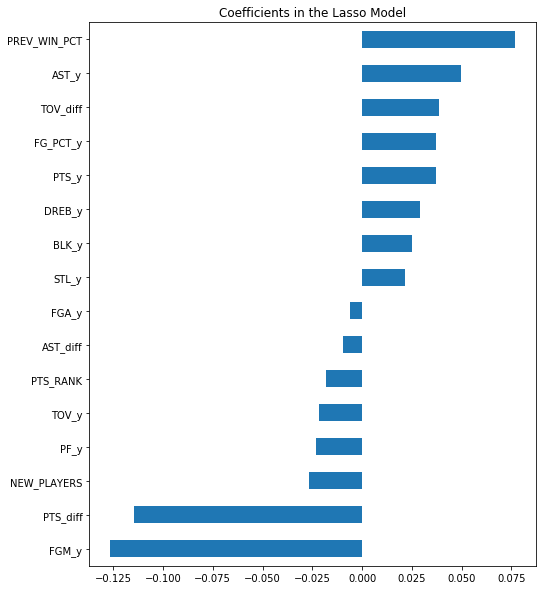

In [118]:
imp_coef = pd.concat([coef.sort_values().head(8),
                     coef.sort_values().tail(8)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")


In [119]:
# Get for each year and team the summed stats of the previous year performance of the players
features = ['FGM', 'FGA', 'FG3M',
       'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS']
stats = []
for index, row in season_2019_df.iterrows():
    season = row["YEAR"]
    prev_season = row["PREV_YEAR"]
    team_id = row["TEAM_ID"]
    time.sleep(1)
    players = commonteamroster.CommonTeamRoster(team_id=team_id, season=season).get_data_frames()[0]["PLAYER_ID"]
    time.sleep(1)
    prev_players = commonteamroster.CommonTeamRoster(team_id=team_id, season=prev_season).get_data_frames()[0]["PLAYER_ID"]

    summed_stats = pd.DataFrame(new_df[(new_df["PLAYER_ID"].isin(players)) & (new_df["SEASON_ID"]==prev_season)][features].sum(axis=0)).transpose()
    summed_stats["YEAR"] = season
    summed_stats["TEAM_ID"] = team_id
    diff_players = len(set(players).difference(set(prev_players)))
    summed_stats["NEW_PLAYERS"] = diff_players
    stats.append(summed_stats)

summed_stats_new = pd.concat(stats, axis=0)
summed_stats_new.head()

,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,YEAR,TEAM_ID,NEW_PLAYERS
0,2794.0,5839.0,684.0,1951.0,1162.0,1552.0,911.0,2444.0,3355.0,1893.0,494.0,376.0,1049.0,1464.0,7434.0,2019-20,1610612737,10
0,2774.0,5977.0,754.0,2124.0,1236.0,1551.0,693.0,2106.0,2799.0,1587.0,544.0,288.0,859.0,1231.0,7538.0,2019-20,1610612738,9
0,2614.0,5525.0,444.0,1265.0,1120.0,1561.0,1165.0,2785.0,3950.0,1349.0,453.0,311.0,925.0,1459.0,6792.0,2019-20,1610612739,9
0,3073.0,6607.0,891.0,2527.0,1112.0,1516.0,648.0,2128.0,2776.0,1773.0,537.0,366.0,959.0,1451.0,8149.0,2019-20,1610612740,12
0,2935.0,6336.0,688.0,1898.0,1204.0,1524.0,746.0,2607.0,3353.0,1969.0,693.0,307.0,983.0,1518.0,7762.0,2019-20,1610612741,7


In [41]:
# Join summed_stats and before_season_df
season_2019_df = season_2019_df.merge(summed_stats_new, on=["YEAR", "TEAM_ID"], how='left')
season_2019_df.head()

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,WIN_PCT,GP,PREV_YEAR,PREV_WIN_PCT,PO_WINS,PO_LOSSES,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,NEW_PLAYERS
0,1610612737,Atlanta,Hawks,2019-20,0.299,67,2018-19,0.354,0.0,0.0,...,911.0,2444.0,3355.0,1893.0,494.0,376.0,1049.0,1464.0,7434.0,10
1,1610612738,Boston,Celtics,2019-20,0.667,72,2018-19,0.598,5.0,4.0,...,693.0,2106.0,2799.0,1587.0,544.0,288.0,859.0,1231.0,7538.0,9
2,1610612739,Cleveland,Cavaliers,2019-20,0.292,65,2018-19,0.232,0.0,0.0,...,1165.0,2785.0,3950.0,1349.0,453.0,311.0,925.0,1459.0,6792.0,9
3,1610612740,New Orleans,Pelicans,2019-20,0.417,72,2018-19,0.402,0.0,0.0,...,648.0,2128.0,2776.0,1773.0,537.0,366.0,959.0,1451.0,8149.0,12
4,1610612741,Chicago,Bulls,2019-20,0.338,65,2018-19,0.268,0.0,0.0,...,746.0,2607.0,3353.0,1969.0,693.0,307.0,983.0,1518.0,7762.0,7


In [42]:
features = ['GP','PREV_WIN_PCT', 'PO_WINS', 'PO_LOSSES',
       'NBA_FINALS_APPEARANCE', 'FGM_x', 'FGA_x', 'FG_PCT', 'FG3M_x', 'FG3A_x',
       'FG3_PCT', 'FTM_x', 'FTA_x', 'FT_PCT', 'OREB_x', 'DREB_x', 'REB_x',
       'AST_x', 'PF_x', 'STL_x', 'TOV_x', 'BLK_x', 'PTS_x', 'PTS_RANK', 'WON',
       'PO_GAMES', 'FGM_y', 'FGA_y', 'FG3M_y',
       'FG3A_y', 'FTM_y', 'FTA_y', 'OREB_y', 'DREB_y', 'REB_y', 'AST_y',
       'STL_y', 'BLK_y', 'TOV_y', 'PF_y', 'PTS_y', "NEW_PLAYERS"]
predict_season_standing(lasso, season_2019_df, features)
season_2019_df.sort_values("PRED_WIN_PCT", ascending=False)[["TEAM_NAME","PRED_WIN_PCT", "WIN_PCT"]].head(30)

,TEAM_NAME,PRED_WIN_PCT,WIN_PCT
12,Bucks,0.710607,0.767
9,Clippers,0.651744,0.681
6,Nuggets,0.628554,0.630
24,Raptors,0.615361,0.736
18,76ers,0.610981,0.589
8,Rockets,0.604329,0.611
16,Magic,0.600894,0.452
25,Jazz,0.579672,0.611
20,Trail Blazers,0.567887,0.473
21,Kings,0.566461,0.431
